In [7]:
import numpy as np
import timeit

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

## Part 1: Michaelis-Menten Equation

### a)

Michaelis constant $K_m$ is the substrate concentration level $[S]$ at which reaction rate is equal to $50 \%$ of the maximum: $v = \frac{V_{\max}}{2}$.

$V_{\max}$ is the maximum (limiting) reaction rate of a system when the substrate concentration approaches $\infin$ (saturation).

### b)

The enzymes in the system appear as either free enzymes $\text{E}$ or are bound in enzyme-substrate complexes $\text{ES}$. The total amount of enzyme in the system is thus:

$$ \text{E}_{\text{total}} = [\text{E}] + [\text{ES}] $$

Since the rate of the catalytic reaction is given as

$$ v = k_{cat} [\text{ES}], $$ 

the maximal rate for fixed $\text{E}_{\text{total}}$ is achieved when all enzymes in the system are bound in enzyme-substrate complexes:

$$ [\text{E}] = 0 $$

$$ \text{E}_{\text{total}} = [\text{ES}] $$

$$ V_{\max} = k_{cat} \text{E}_{\text{total}} $$

### c)

In this highly unlikely case, the assumption fails. The $V_{\max} = k_{cat} \text{E}_{\text{total}}$ assumption is strongly based on the $[S] \gg [E]$. In the "$v$ vs $[S]$ plot", as $[S]$ approaches infinity, the saturation starts to occur - all existing enzymes bind with the substrates, forming ES complex. 

At some (hypothetical) point there is no more enzymes left to interact with substrate to produce ES. The maximum rate $V_{\max}$ is thus restriscted by the total amount of enzymes $E_{total}$. This statement wouldn't be true if $[S] \gg [E]$.

### d), e), f) Plotting reaction rate against substrate concentration

In [8]:
kms = [1, 0.5, 1]
vmaxs = [25, 25, 15]
srange = np.linspace(0, 10, 1000)

plot_colours = ["darkred", "blue", "darkgreen"]

In [9]:
def plot_v_vs_s(ax, srange: np.ndarray, km: float, vmax: float, col="blue"):
    # Reaction rate (y-axis) values
    vv = vmax * (srange / (srange + km))

    # Plot the smooth line
    ax.plot(srange, vv, color=col, label=f'$K_m={km}, V_{{max}}={vmax}$', lw=2.5)

    # Plot horizontal dotted lines at 0.5*vmax and vmax
    ax.hlines(vmax, srange[0], srange[-1], linestyles="dashed")
    ax.hlines(0.5 * vmax, srange[0], km, linestyles="dotted")

    # Add 0.5*vmax, vmax y-ticks
    yticks = [*ax.get_yticks(), 0.5 * vmax, vmax]
    yticklabels = [*ax.get_yticklabels(), r"$0.5 V_{\max}$ = " + f"{0.5*vmax}", r"$V_{\max}$ = " + f"{vmax}"]
    ax.set_yticks(yticks, labels=yticklabels)

    # # Change colours of 0.5*vmax, vmax y-ticks
    # I REGRET MY DECISIONS
    # vind = np.where(ax.get_yticks() == 0.5*vmax)[0][0]
    # ax.yaxis.get_ticklabels()[vind].set_color(col)
    # vind = np.where(ax.get_yticks() == vmax)[0][0]
    # ax.yaxis.get_ticklabels()[vind].set_color(col)
    
    # Plot vertical dotted lines at km
    ax.vlines(km, vv[0], 0.5 * vmax, linestyles="dotted")

    # Add km x-tick
    xticks = [*ax.get_xticks(), km]
    xticklabels = [*ax.get_xticklabels(), r"$K_m = $" + f"{km}"]
    ax.set_xticks(xticks, labels=xticklabels, rotation=45)

    # # Change colour of km x-tick
    # vind = np.where(ax.get_xticks() == km)[0][0]
    # ax.xaxis.get_ticklabels()[vind].set_color(col)

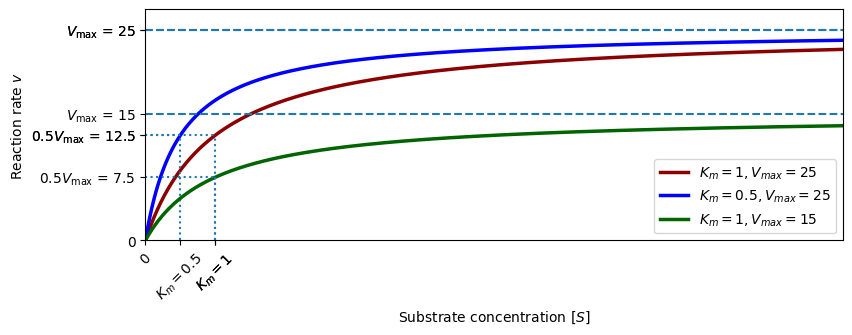

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.set_xticks([0])
ax.set_yticks([0])
ax.set_xlim((srange[0], srange[-1]))
ax.set_ylim((0, max(vmaxs) * 1.1))

ax.set_xlabel("Substrate concentration " + r"$[S]$")
ax.set_ylabel("Reaction rate " + r"$v$")

for (km, vmax, pc) in zip(kms, vmaxs, plot_colours):
    plot_v_vs_s(ax, srange, km, vmax, col=pc)

ax.legend(loc="lower right")
plt.show()

The red plot shows resulting reaction rate $v$ plotted against substrate concentration $[S]$ for $K_m = 1$ and $V_{\max} = 25$. 

The reaction occurs faster (rate grows) when substrate is added to the system. Rate grows the quicker, the less substrate there already is in the system. Once substrate concentration $[S]$ reaches the level of Michaelis constant $K_m$, the reaction rate $v$ is $50\%$ of the maximum $V_{\max}$. 

When there already is a lot of substrate in the system ($[S]$ is large), the reaction rate $v$ grows very slowly. This is because the problem then becomes the insufficient amount of enzyme, rather than substrate. There is not many enzyme molecules left to bind with the substrates and create $ES$ complexes. The system becomes saturated.

When $K_m$ is lowered to $0.5$ (blue line), the initial growth of $v$ becomes faster. Reaction rate $v$ reaches $50\% V_{\max}$ more quickly. Since $V_{\max}$ is kept constant, the gap between the red and blue lines becomes $0$ in the limit of large $[S]$.

When $V_{\max}$ is lowered to $15$ (green line), the initial and overall growth of $v$ becomes sloewr. Reaction rate $v$ reaches $50\% V_{\max}$ at the same substrate concentration, but this value is now lower. The catalytic reaction will occur more gradually as compared with the experiment with $V_{\max} = 25$.

### g)

Maximal reaction rate $V_{\max} = E_{total} k_{cat} $ would become twice as big.

Michaelis constant $K_m = \frac{k_{-} + k_{cat}}{k_{+}}$, dependent only on kinetic rate constants, would remain the same.

## Part 2: Lineweaver-Burk

### a) Plotting data & retrieving parameters with `curve_fit()`

In [11]:
data = np.loadtxt("data/Data/measuredData.csv", delimiter=",").T

ss = data[0]
vv = data[1]

In [12]:
def michaelis_menten_equation(s, vmax, km):
    return vmax * (s / (s + km))

popt, _ = curve_fit(michaelis_menten_equation, ss, vv)
vmaxopt, kmopt = popt

Estimated Vmax = 9.95
Estimated Km = 0.46


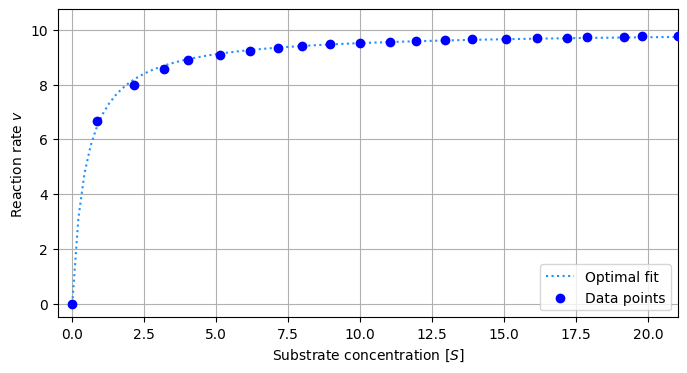

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_xlim((-0.5, max(ss)))
ax.set_ylim((-0.5, 1.1*max(vv)))

ax.set_xlabel("Substrate concentration " + r"$[S]$")
ax.set_ylabel("Reaction rate " + r"$v$")

ax.grid()

xxopt = np.linspace(min(ss), max(ss), 100)
ax.plot(xxopt, michaelis_menten_equation(xxopt, vmaxopt, kmopt), ls="dotted",  color="dodgerblue", label="Optimal fit")

ax.scatter(ss, vv, color="blue", label="Data points", zorder=10)

ax.legend(loc="lower right")

print(f"Estimated Vmax = {np.round(vmaxopt, 2)}")
print(f"Estimated Km = {np.round(kmopt, 2)}")

plt.show()

### b) Lineweaver-Burk plot

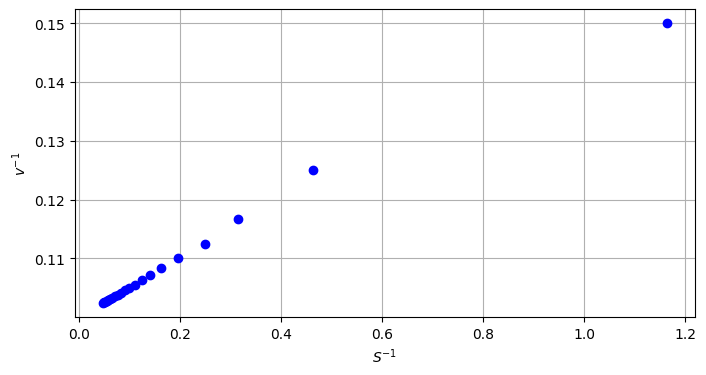

In [14]:
ssinv = 1 / ss[1:]
vvinv = 1 / vv[1:]

fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_xlabel(r"$S^{-1}$")
ax.set_ylabel(r"$v^{-1}$")

ax.grid()

ax.scatter(ssinv, vvinv, color="blue", zorder=10)

plt.show()

The plot now shows a linear relation between $\frac{1}{V}$ and $\frac{1}{S}$ instead of a logarithmic (TODO: is that right ?) between $v$ and $S$. This means that $v^{-1}$ can possibly be expressed in terms of $S^{-1}$ in the following way:

$$ v^{-1} = a S^{-1} + b $$

### c) Derivation of $a,b$

$$ 
\begin{equation}
\begin{split}
v &= \frac{V_{\max}S}{S + K_m} \\
\frac{1}{v} &= \frac{S + K_m}{V_{\max}S} \\
\frac{1}{v} &= \frac{1}{V_{\max}} + \frac{K_m}{V_{\max}S} \\
\\
a &= \frac{1}{V_{\max}} \; \; \; \; \; b = \frac{K_m}{V_{\max}}
\end{split}
\end{equation} 
$$

### d) Intersections

$$ v^{-1}(S^{-1}) = \frac{1}{V_{\max}} + \frac{K_m}{V_{\max}} S^{-1} $$

---

Vertical axis $\rightarrow S^{-1} = 0$

$$ v^{-1}(0) = \frac{1}{V_{\max}} + \frac{K_m}{V_{\max}} \cdot 0 = \frac{1}{V_{\max}} $$

The intersection point is $\{ 0, \frac{1}{V_{\max}} \}$.

---

Horizontal axis $\rightarrow v^{-1} = 0$

\begin{equation}
\begin{split}
\frac{1}{V_{\max}} + \frac{K_m}{V_{\max}} \cdot S^{-1} &= 0 \\
\frac{K_m}{V_{\max}} \cdot S^{-1} &= -\frac{1}{V_{\max}} \\
S^{-1} &= -\frac{1}{K_m} \\
\end{split}
\end{equation}

The intersection point is $\{ -\frac{1}{K_m}, 0 \}$.


### e) Retrieving the parameters

In [15]:
def linear_equation(sinv, a, b):
    return a + b * sinv

popt, _ = curve_fit(linear_equation, ssinv, vvinv)
a, b = popt

vmaxopt = 1 / a
kmopt = b / a

print(f"Estimated Vmax = {np.round(vmaxopt, 2)}")
print(f"Estimated Km = {np.round(kmopt, 2)}")

Estimated Vmax = 9.92
Estimated Km = 0.44


$V_{\max}$, $K_{m}$ obtained with Lineweaver-Burk plot $(9.92, 0.44)$ correspond well with values obtained with `curve_fit()` method $(9.95, 0.46)$

### f) Advantages

The biggest advantage of obtaining the parameters with Lineweaver-Burk plot is that this can be done without the use of computer (although it would still require some computational work). If one was ever stuck on a desert island and needed to estimate parameters of Michaelis-Menten Equation, the Lineweaver-Burk plot could come in handy.

The disdadvantage of this method is mostly its lack of versatility. The method is undefined for $S = 0$ and sensitive when estimating parameter $a$. (TODO: Is that even correct lol).

## Part 3: Inhibitors

### a)

The $E_{total}$ is defined as the total amount of enzyme in all complexes in the system. With the introduction of inhibitors, we now have to also keep track of the complexes formed by the interaction of specific inhibitors with the enzymes.

##### Competitive inhibitors

The new complex is $EI$. Thus:

$$ E_{total} = [E] + [ES] + [EI] = [E] + [ES] + \frac{[I][E]}{K_i} = [ES] + (1 + \frac{[I]}{K_i}) [E] $$

##### Uncompetitive inhibitors

The new complex is $ESI$. Thus:

$$ E_{total} = [E] + [ES] + [ESI] = [E] + [ES] + \frac{[I][ES]}{K_i} = [E] + (1 + \frac{[I]}{K_i}) [ES] $$

##### Noncompetitive inhibitors

The new complexes are $EI$ and $ESI$. Thus:

$$ E_{total} = [E] + [ES] + [EI] + [ESI] = [E] + [ES] + \frac{[I][E]}{K_i} + \frac{[I][ES]}{K_i} = (1 + \frac{[I]}{K_i})([ES] + [E]) $$

### b)

All steps untill achieving $K_m [ES] = [E][S]$ are the same. The $[E]$ is then substituted accordingly to obtained $E_{total}$ and transformed to obtain $[ES]$ on the left side. We begin the derivation for all inhibitors from that step. The resulting $[ES]$ is substituted to $v = k_{cat}[ES]$.

#### Competitive inhibitors

Derivation of $[ES]$

$$
\begin{equation}
\begin{split}
K_m[ES] &= [E][S] \\
K_m[ES] &= (\frac{E_{total} - [ES]}{1 + \frac{[I]}{K_i}})[S] \\
[ES](K_m + \frac{[S]}{1 + \frac{[I]}{K_i}}) &= \frac{E_{total} [S]}{1 + \frac{[I]}{K_i}} \\
[ES](K_m (1 + \frac{[I]}{K_i}) + [S]) &= E_{total} [S] \\
[ES] &= E_{total} \cdot \frac{[S]}{K_m (1 + \frac{[I]}{K_i}) + [S]}
\end{split}
\end{equation}
$$

Substitution to $v = k_{cat}[ES]$

$$ v_c = k_{cat} E_{total} \cdot \frac{[S]}{K_m (1 + \frac{[I]}{K_i}) + [S]} = V_{\max} \frac{[S]}{K_m (1 + \frac{[I]}{K_i}) + [S]} $$

---

#### Uncompetitive inhibitors

$$
\begin{equation}
\begin{split}
K_m[ES] &= [E][S] \\
K_m[ES] &= (E_{total} - (1 + \frac{[I]}{K_i})[ES])[S] \\
[ES](K_m + (1 + \frac{[I]}{K_i})[S]) &= E_{total}[S] \\
[ES] &= E_{total} \cdot \frac{[S]}{K_m + (1 + \frac{[I]}{K_i})[S]}
\end{split}
\end{equation}
$$

Substitution to $v = k_{cat}[ES]$

$$ v_u = k_{cat} E_{total} \cdot \frac{[S]}{K_m + (1 + \frac{[I]}{K_i})[S]} = V_{\max} \frac{[S]}{K_m + (1 + \frac{[I]}{K_i})[S]} $$

---

##### Noncompetitive inhibitors

$$
\begin{equation}
\begin{split}
K_m[ES] &= [E][S] \\
K_m[ES] &= (\frac{E_{total}}{1 + \frac{[I]}{K_i}} - [ES])[S] \\
[ES](K_m + [S]) &= (\frac{E_{total}}{1 + \frac{[I]}{K_i}})[S] \\
[ES] &= E_{total} \cdot \frac{[S]}{(1 + \frac{[I]}{K_i})(K_m + [S])}
\end{split}
\end{equation}
$$

Substitution to $v = k_{cat}[ES]$

$$ v_u = k_{cat} E_{total} \cdot \frac{[S]}{(1 + \frac{[I]}{K_i})(K_m + [S])} = V_{\max} \frac{[S]}{(1 + \frac{[I]}{K_i})(K_m + [S])} $$

---

### c)

#### Competitive inhibitors

$$ v_c = V_{\max} \frac{[S]}{(1 + \frac{[I]}{K_i})K_m + [S]} $$

Here, $K_m$ is scaled by a factor $(1 + \frac{[I]}{K_i})$. We expect the $50\% V_{\max}$ threshold to be achieved at higher $[S]$ concentration level compared to model without inhibitor and the overall increase in reaction rate will be slower-paced, with the maximal rate $V_{\max}$ remaining unchanged. The new $50\% V_{\max}$ concentration level will be the larger the higher the inhibitor concentration $[I]$ and the lower the inhibition constant $K_i$.

#### Uncompetitive inhibitors

$$ v_u = V_{\max} \frac{[S]}{K_m + (1 + \frac{[I]}{K_i})[S]} $$

Here, $[S]$ in the denominator is scaled by a factor $(1 + \frac{[I]}{K_i})$. We expect the $50\% V_{\max}$ threshold to be achieved at lower $[S]$ concentration level compared to model without inhibitor and the overall increase in reaction rate will be faster-paced, with the maximal rate $V_{\max}$ remaining unchanged. The new $50\% V_{\max}$ concentration level will be the smaller the higher the inhibitor concentration $[I]$ and the lower the inhibition constant $K_i$.

#### Noncompetitive inhibitors

$$ v_n = V_{\max} \frac{[S]}{(1 + \frac{[I]}{K_i})(K_m + [S])} = \frac{V_{\max}}{(1 + \frac{[I]}{K_i})} \cdot \frac{[S]}{(K_m + [S])} $$

Here, $V_{\max}$ is divided by a factor $(1 + \frac{[I]}{K_i})$. We expect the $50\% V_{\max}$ threshold to be achieved at exact same $[S]$ concentration level compared to model without inhibitor, with the maximal rate $V_{\max}$ lower than in the basic model. Due to the decrease of $V_{\max}$, the overall rate increase will be smaller. The new maximum rate $V_{\max}$ will be the smaller the higher the inhibitor concentration $[I]$ and the lower the inhibition constant $K_i$.

### d) Plot for competitive inhibitor

In [16]:
def michaelis_menten(s, vmax, km):
    """Computes v reaction rate for the basic michaelis-menten model.

    Args:
        s (np.ndarray): list of substrate concentration values
        vmax (float): maximum reaction rate
        km (float): Michaelis constant
    """    
    return vmax * (s / (km + s))

In [17]:
def competitive_inhibitor_rate(s, vmax, km, i, ki):
    """Computes v_c reaction rate for the model with competitive inhibitor.

    Args:
        s (np.ndarray): list of substrate concentration values
        vmax (float): maximum reaction rate
        km (float): Michaelis constant
        i (float): inhibitor concentration
        ki (float): inhibition constant
    """    
    return vmax * (s / ((1 + (i / ki)) * km + s))

In [18]:
km = 1
vmax = 12
srange = np.linspace(0, 14, 1000)

iss = [2, 2, 5]
kis = [2, 5, 2]
plot_colours = ["darkred", "blue", "darkgreen"]

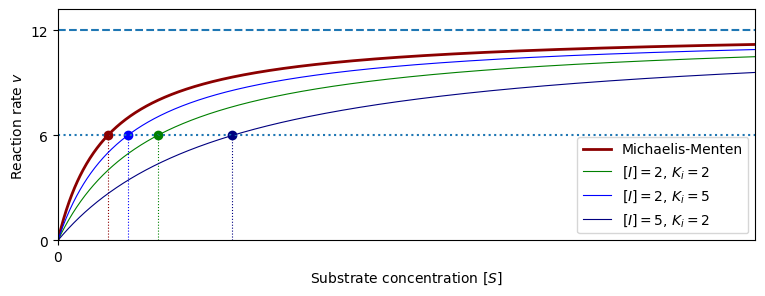

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
# Plot setup
ax.set_xticks([0])
ax.set_yticks([0, 0.5*vmax, vmax])
ax.set_xlim((srange[0], srange[-1]))
ax.set_ylim((0, vmax * 1.1))

ax.set_xlabel("Substrate concentration " + r"$[S]$")
ax.set_ylabel("Reaction rate " + r"$v$")

# Horizontal lines for Vmax and 50%*Vmax
ax.hlines(vmax, srange[0], srange[-1], linestyles="dashed")
ax.hlines(0.5 * vmax, srange[0], srange[-1], linestyles="dotted")

# Basic Michaelis-Menten
vs = michaelis_menten(srange, vmax, km)
ax.plot(srange, vs, label=r"Michaelis-Menten", color="darkred", lw=2.0)
ax.vlines(km, 0, 0.5*vmax, linestyles="dotted", color="darkred", lw=0.8)
ax.scatter(km, 0.5*vmax, color="darkred")

# I = 2, Ki = 2
vs = competitive_inhibitor_rate(srange, vmax, km, iss[0], kis[0])
ax.plot(srange, vs, label=r"$[I]=$" + f"{iss[0]}, " + r"$K_i=$" + f"{kis[0]}", color="green", lw=0.8)
ax.vlines((1 + iss[0]/kis[0])*km, 0, 0.5*vmax, linestyles="dotted", color="green", lw=0.8)
ax.scatter((1 + iss[0]/kis[0])*km, 0.5*vmax, color="green")

# I = 2, Ki = 5
vs = competitive_inhibitor_rate(srange, vmax, km, iss[1], kis[1])
ax.plot(srange, vs, label=r"$[I]=$" + f"{iss[1]}, " + r"$K_i=$" + f"{kis[1]}", color="blue", lw=0.8)
ax.vlines((1 + iss[1]/kis[1])*km, 0, 0.5*vmax, linestyles="dotted", color="blue", lw=0.8)
ax.scatter((1 + iss[1]/kis[1])*km, 0.5*vmax, color="blue")

# I = 5, Ki = 2
vs = competitive_inhibitor_rate(srange, vmax, km, iss[2], kis[2])
ax.plot(srange, vs, label=r"$[I]=$" + f"{iss[2]}, " + r"$K_i=$" + f"{kis[2]}", color="navy", lw=0.8)
ax.vlines((1 + iss[2]/kis[2])*km, 0, 0.5*vmax, linestyles="dotted", color="navy", lw=0.8)
ax.scatter((1 + iss[2]/kis[2])*km, 0.5*vmax, color="navy")

ax.legend(loc="lower right")
plt.show()

The red line shows the basic Michaelis-Menten plot for the provided set of parameters. The green line shows the model with inhibitors introduced and $[I] = 2, K_i = 2$, therefore $v_c = V_{\max} \frac{[S]}{2K_m + [S]}$. Indeed, the reaction rate reaches $50\%$ of the maximum at twice the substrate concentration $[S]$ as compared with basic Michaelis-Menten model.

Introducing inhibitors causes the substrate $S$ to compete for the resources (enzymes $E$) with the inhibitors. As a result, some of the enzymes that would normally form $ES$ complexes now bind to the inhibitor forming $EI$. There is smaller amount of $ES$ complexes in the system and thus the rate of the catalytic reaction is also smaller.

Light blue line shows the inhibitor plot for $[I] = 2, K_i = 5$, therefore $v_c = V_{\max} \frac{[S]}{1.4K_m + [S]}$. The $50\%$ max rate concentration is achieved for smaller $[S]$ and the overall relation between $v$ and $[S]$ got closer in shape to the basic Michaelis-Menten model.

At a molecular level, the rate of $E + I \leftrightarrow EI$ reaction became slower. The inhibitors became less likely to bind with the enzymes, resulting in less competition for $S$ and therefore more $ES$ and higher $v_c$.

Dark blue line shows the inhibitor plot for $[I] = 5, K_i = 2$, therefore $v_c = V_{\max} \frac{[S]}{3.5K_m + [S]}$. The $50\%$ max rate concentration is achieved for even bigger $[S]$ as compared to basic inhibitor model. Even more substrate is needed to achieve maximum reaction rate.

At a molecular level, the rate of $E + I \leftrightarrow EI$ was fixed (compared to green line), but more inhibitors were introduced in the system. The inhibitors were as competitive as before, but, since there were more of them, this resulted in more competition for $S$ and therefore less $ES$ and smaller $v_c$.

### e) Inhibitor datasets

We can start by deriving the linear relation between $v^{-1}$ and $S^{-1}$ in the form:

$$ \frac{1}{V} = a + b \frac{1}{S} $$

for all inhibitors.

#### Competitive inhibitors

\begin{equation}
\begin{split}
v_c &= V_{\max} \frac{[S]}{(1 + \frac{[I]}{K_i})K_m + [S]} \\
\frac{1}{v_c} &= \frac{(1 + \frac{[I]}{K_i})K_m + [S]}{V_{\max}[S]} \\
\frac{1}{v_c} &= \frac{(1 + \frac{[I]}{K_i})K_m}{V_{\max}}S^{-1} + \frac{1}{V_{\max}} \\
\end{split}
\end{equation}

In the following relation, the $[I]$ term is only present in the slope of the linear equation. If the inhibitor $[I]$ is competitive, the three Lineweaver-Burk plots will only differ in slope.

#### Uncompetitive inhibitors

\begin{equation}
\begin{split}
v_u &= V_{\max} \frac{[S]}{K_m + (1 + \frac{[I]}{K_i})[S]} \\
\frac{1}{v_u} &= \frac{K_m + (1 + \frac{[I]}{K_i})[S]}{V_{\max}[S]} \\
\frac{1}{v_u} &= \frac{K_m}{V_{\max}} S^{-1} + \frac{(1 + \frac{[I]}{K_i})}{V_{\max}} \\
\end{split}
\end{equation}

In the following relation, the $[I]$ term is only present in the intercept of the linear equation. If the inhibitor $[I]$ is uncompetitive, the three Lineweaver-Burk plots will only differ in intercept.

#### Noncompetitive inhibitors

$$ 
\begin{equation}
\begin{split}
v_n = V_{\max} \frac{[S]}{(1 + \frac{[I]}{K_i})(K_m + [S])} \\
\frac{1}{v_n} = \frac{(1 + \frac{[I]}{K_i})(K_m + [S])}{V_{\max}[S]} \\
\frac{1}{v_n} = \frac{(1 + \frac{[I]}{K_i})K_m}{V_{\max}}S^{-1} + \frac{(1 + \frac{[I]}{K_i})}{V_{\max}} \\
\end{split}
\end{equation}
$$

In the following relation, the $[I]$ term is present both in the intercept and slope of the linear equation. If the inhibitor $[I]$ is noncompetitive, the three Lineweaver-Burk plots will differ in both intercept and slope.

In [49]:
ss2, vv2 = np.genfromtxt("data/Data/DataI2.csv", delimiter=",").T
ss5, vv5 = np.genfromtxt("data/Data/DataI5.csv", delimiter=",").T
ss8, vv8 = np.genfromtxt("data/Data/DataI8.csv", delimiter=",").T

xx = np.linspace(-0.05, 1.1, 1000)

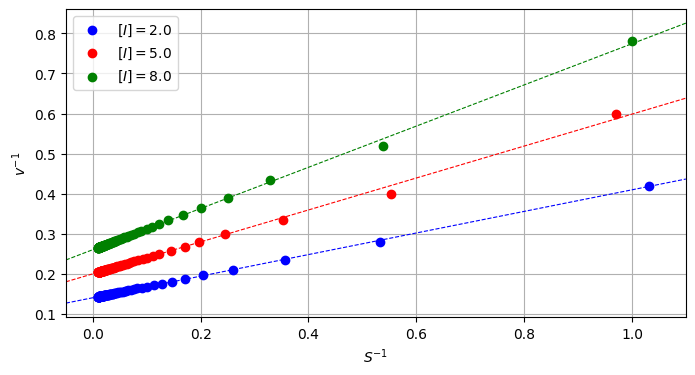

In [53]:
ssinv2, vvinv2 = 1 / ss2[1:], 1 / vv2[1:]
ssinv5, vvinv5 = 1 / ss5[1:], 1 / vv5[1:]
ssinv8, vvinv8 = 1 / ss8[1:], 1 / vv8[1:]

fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_xlabel(r"$S^{-1}$")
ax.set_ylabel(r"$v^{-1}$")

ax.set_xlim((-0.05, 1.1))

ax.grid()

ax.scatter(ssinv2, vvinv2, color="blue", zorder=10, label=r"$[I]=2.0$")
popt2, _ = curve_fit(linear_equation, ssinv2, vvinv2)
a, b = popt2
ax.plot(xx, linear_equation(xx, a, b), ls="dashed", color="blue", lw=0.8)

ax.scatter(ssinv5, vvinv5, color="red", zorder=10, label=r"$[I]=5.0$")
popt5, _ = curve_fit(linear_equation, ssinv5, vvinv5)
a, b = popt5
ax.plot(xx, linear_equation(xx, a, b), ls="dashed", color="red", lw=0.8)

ax.scatter(ssinv8, vvinv8, color="green", zorder=10, label=r"$[I]=8.0$")
popt8, _ = curve_fit(linear_equation, ssinv8, vvinv8)
a, b = popt8
ax.plot(xx, linear_equation(xx, a, b), ls="dashed", color="green", lw=0.8)

ax.legend()

plt.show()

The linear fits differ in both intercept and slope, therefore inhibitor $[I]$ has to be noncompetitive.